**Mapping Sysmon logs to Cyber Kill Chain stages**

In [2]:
import pandas as pd

def label_with_cyber_kill_chain(row):

    if row['EventID'] == 1:
        if 'powershell' in str(row['Image']).lower() or '-enc' in str(row['CommandLine']).lower():
            return 'weaponization'  # Weaponization (PowerShell commands, malware execution)

    # Event ID 2: File creation time changed is a not part of the Cyber Kill Chain unless unusual
    if row['EventID'] == 2:
        return 'benign'

    if row['EventID'] == 3:
        if row['DestinationIp'] not in ['192.', '10.', '172.']:  # External connections
            return 'reconnaissance'
        if row['DestinationPort'] not in [80, 443, 53]:  # Uncommon ports for network traffic
            return 'c2'  # Command and Control (C2) communication

    if row['EventID'] == 5:
        return 'benign'

    if row['EventID'] == 6:
        if 'malicious_driver.sys' in str(row['ImageLoaded']):
            return 'delivery'  # Delivery of malicious payload or driver

    if row['EventID'] == 7:
        return 'exploitation'  # malicious image loading into another process

    if row['EventID'] == 8:
        return 'exploitation'  # DLL injection, code execution in other processes

    if row['EventID'] == 10:
        return 'benign'

    if row['EventID'] == 11:
        if 'suspicious_file.exe' in str(row['TargetFilename']):
            return 'installation'  # potential malware dropped on system

    if row['EventID'] == 12:
        if 'malicious_key' in str(row['TargetObject']):
            return 'installation'  # persistence through registry modifications

    if row['EventID'] == 13:
        if 'malicious_value' in str(row['TargetObject']):
            return 'installation'  # registry manipulation

    if row['EventID'] == 15:
        if 'malicious_stream' in str(row['TargetFilename']):
            return 'delivery'  # malicious file access or delivery

    if row['EventID'] == 22:
        if 'suspicious_domain' in str(row['QueryName']):
            return 'reconnaissance'  # external scanning or C2 via DNS

    if row['EventID'] == 23:
        return 'benign'

    if row['EventID'] == 24:
        return 'benign'

    if row['EventID'] == 25:
        return 'actions_on_objectives'  # hiding or modifying system processes

    # If no relevant stage identified, labeled as benign
    return 'benign'

**Importing the Sysmon log data set exported from Splunk**

In [3]:
df = pd.read_csv('CKC_data.csv')

# Applying cyber kill chain stage labeling
df['CKC_Stage'] = df.apply(label_with_cyber_kill_chain, axis=1)
print(df[['EventID', 'Message', 'CKC_Stage']].head())

<ipython-input-3-cf28a43266aa>:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('CKC_data.csv')


   EventID                                            Message CKC_Stage
0        1  Process Create: C:\Program Files\Splunk\bin\sp...    benign
1        1  Process Create: C:\Program Files\Splunk\bin\sp...    benign
2       13  Registry value set: HKLM\SOFTWARE\Microsoft\Wi...    benign
3       13  Registry value set: HKLM\SOFTWARE\Microsoft\Wi...    benign
4       13  Registry value set: HKLM\SOFTWARE\Microsoft\Wi...    benign


In [4]:
df.head()

,_time,Computer,User,EventID,Message,ProcessId,ParentProcessId,Image,ParentImage,CommandLine,...,DestinationPort,TargetFilename,TargetObject,QueryName,ClientIp,GrantedAccess,SourceImage,TargetImage,Details,CKC_Stage
0,1.745129e+09,Malavika,NT AUTHORITY\SYSTEM,1,Process Create: C:\Program Files\Splunk\bin\sp...,26612,5888.0,C:\Program Files\Splunk\bin\splunk-optimize.exe,C:\Program Files\Splunk\bin\splunkd.exe,"splunk-optimize -d ""C:\Program Files\Splunk\va...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,benign
1,1.745129e+09,Malavika,NT AUTHORITY\SYSTEM,1,Process Create: C:\Program Files\Splunk\bin\sp...,25376,5888.0,C:\Program Files\Splunk\bin\splunk-optimize.exe,C:\Program Files\Splunk\bin\splunkd.exe,"splunk-optimize -d ""C:\Program Files\Splunk\va...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,benign
2,1.745129e+09,Malavika,NT AUTHORITY\SYSTEM,13,Registry value set: HKLM\SOFTWARE\Microsoft\Wi...,3152,NaN,C:\WINDOWS\system32\svchost.exe,NaN,NaN,...,NaN,NaN,HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion...,NaN,NaN,NaN,NaN,NaN,QWORD (0x01dbb1ba-0x376fff48),benign
3,1.745129e+09,Malavika,NT AUTHORITY\SYSTEM,13,Registry value set: HKLM\SOFTWARE\Microsoft\Wi...,3152,NaN,C:\WINDOWS\system32\svchost.exe,NaN,NaN,...,NaN,NaN,HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion...,NaN,NaN,NaN,NaN,NaN,DWORD (0x00000001),benign
4,1.745129e+09,Malavika,NT AUTHORITY\SYSTEM,13,Registry value set: HKLM\SOFTWARE\Microsoft\Wi...,3152,NaN,C:\WINDOWS\system32\svchost.exe,NaN,NaN,...,NaN,NaN,HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion...,NaN,NaN,NaN,NaN,NaN,QWORD (0x00000000-0x00000000),benign


In [5]:
df['is_threat'] = df['CKC_Stage'].apply(lambda x: 'threat' if x != 'benign' else 'benign')

In [6]:
df.head()

,_time,Computer,User,EventID,Message,ProcessId,ParentProcessId,Image,ParentImage,CommandLine,...,TargetFilename,TargetObject,QueryName,ClientIp,GrantedAccess,SourceImage,TargetImage,Details,CKC_Stage,is_threat
0,1.745129e+09,Malavika,NT AUTHORITY\SYSTEM,1,Process Create: C:\Program Files\Splunk\bin\sp...,26612,5888.0,C:\Program Files\Splunk\bin\splunk-optimize.exe,C:\Program Files\Splunk\bin\splunkd.exe,"splunk-optimize -d ""C:\Program Files\Splunk\va...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,benign,benign
1,1.745129e+09,Malavika,NT AUTHORITY\SYSTEM,1,Process Create: C:\Program Files\Splunk\bin\sp...,25376,5888.0,C:\Program Files\Splunk\bin\splunk-optimize.exe,C:\Program Files\Splunk\bin\splunkd.exe,"splunk-optimize -d ""C:\Program Files\Splunk\va...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,benign,benign
2,1.745129e+09,Malavika,NT AUTHORITY\SYSTEM,13,Registry value set: HKLM\SOFTWARE\Microsoft\Wi...,3152,NaN,C:\WINDOWS\system32\svchost.exe,NaN,NaN,...,NaN,HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion...,NaN,NaN,NaN,NaN,NaN,QWORD (0x01dbb1ba-0x376fff48),benign,benign
3,1.745129e+09,Malavika,NT AUTHORITY\SYSTEM,13,Registry value set: HKLM\SOFTWARE\Microsoft\Wi...,3152,NaN,C:\WINDOWS\system32\svchost.exe,NaN,NaN,...,NaN,HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion...,NaN,NaN,NaN,NaN,NaN,DWORD (0x00000001),benign,benign
4,1.745129e+09,Malavika,NT AUTHORITY\SYSTEM,13,Registry value set: HKLM\SOFTWARE\Microsoft\Wi...,3152,NaN,C:\WINDOWS\system32\svchost.exe,NaN,NaN,...,NaN,HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion...,NaN,NaN,NaN,NaN,NaN,QWORD (0x00000000-0x00000000),benign,benign


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518736 entries, 0 to 518735
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   _time              518736 non-null  float64
 1   Computer           518736 non-null  object 
 2   User               518736 non-null  object 
 3   EventID            518736 non-null  int64  
 4   Message            518736 non-null  object 
 5   ProcessId          518736 non-null  int64  
 6   ParentProcessId    64030 non-null   float64
 7   Image              518736 non-null  object 
 8   ParentImage        64030 non-null   object 
 9   CommandLine        64030 non-null   object 
 10  ParentCommandLine  64030 non-null   object 
 11  DestinationIp      1296 non-null    object 
 12  DestinationPort    1296 non-null    float64
 13  TargetFilename     1358 non-null    object 
 14  TargetObject       450417 non-null  object 
 15  QueryName          1633 non-null    object 
 16  Cl

**Removing unnecessary columns**

In [8]:
df = df.drop(columns=['Computer', 'User', 'ParentProcessId', 'ParentImage', 'CommandLine','ParentCommandLine', 'ClientIp', 'GrantedAccess', 'SourceImage', 'TargetImage', 'Details'])

In [9]:
df.head()

,_time,EventID,Message,ProcessId,Image,DestinationIp,DestinationPort,TargetFilename,TargetObject,QueryName,CKC_Stage,is_threat
0,1.745129e+09,1,Process Create: C:\Program Files\Splunk\bin\sp...,26612,C:\Program Files\Splunk\bin\splunk-optimize.exe,NaN,NaN,NaN,NaN,NaN,benign,benign
1,1.745129e+09,1,Process Create: C:\Program Files\Splunk\bin\sp...,25376,C:\Program Files\Splunk\bin\splunk-optimize.exe,NaN,NaN,NaN,NaN,NaN,benign,benign
2,1.745129e+09,13,Registry value set: HKLM\SOFTWARE\Microsoft\Wi...,3152,C:\WINDOWS\system32\svchost.exe,NaN,NaN,NaN,HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion...,NaN,benign,benign
3,1.745129e+09,13,Registry value set: HKLM\SOFTWARE\Microsoft\Wi...,3152,C:\WINDOWS\system32\svchost.exe,NaN,NaN,NaN,HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion...,NaN,benign,benign
4,1.745129e+09,13,Registry value set: HKLM\SOFTWARE\Microsoft\Wi...,3152,C:\WINDOWS\system32\svchost.exe,NaN,NaN,NaN,HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion...,NaN,benign,benign


In [10]:
df.isnull().sum().sort_values(ascending=False)

,0
DestinationPort,517440
DestinationIp,517440
TargetFilename,517378
QueryName,517103
TargetObject,68319
Message,0
EventID,0
_time,0
ProcessId,0
Image,0


**Handling missing values**

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

**Although DestinationIP or Port fields have many missing values, they are critical for identifying Command & Control activities in the Cyber Kill Chain. I kept them and used placeholder values like '0.0.0.0' and -1 to preserve the information without affecting the model.**

In [12]:
df['DestinationIp'] = df['DestinationIp'].fillna('0.0.0.0')
df['DestinationPort'] = df['DestinationPort'].fillna(-1)     # Use -1 for unknown port

df['TargetFilename'] = df['TargetFilename'].fillna('unknown_filename')
df['TargetObject'] = df['TargetObject'].fillna('unknown_object')

df['QueryName'] = df['QueryName'].fillna('unknown_query')

df['Message'] = df['Message'].fillna('no_message')

#we don't have any missing values for CKC_Stage and is_threat
#df['CKC_Stage'] = df['CKC_Stage'].fillna('benign')
#df['is_threat'] = df['is_threat'].fillna('benign')

In [13]:
print("Missing values after cleaning:")
df.isnull().sum().sort_values(ascending=False)

Missing values after cleaning:


,0
_time,0
EventID,0
Message,0
ProcessId,0
Image,0
DestinationIp,0
DestinationPort,0
TargetFilename,0
TargetObject,0
QueryName,0


**Data after handling Missing values and datatypes**

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518736 entries, 0 to 518735
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   _time            518736 non-null  float64
 1   EventID          518736 non-null  int64  
 2   Message          518736 non-null  object 
 3   ProcessId        518736 non-null  int64  
 4   Image            518736 non-null  object 
 5   DestinationIp    518736 non-null  object 
 6   DestinationPort  518736 non-null  float64
 7   TargetFilename   518736 non-null  object 
 8   TargetObject     518736 non-null  object 
 9   QueryName        518736 non-null  object 
 10  CKC_Stage        518736 non-null  object 
 11  is_threat        518736 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 47.5+ MB


**Encoding** - encoding categorical data and target variable 'is_threat' to binary

In [15]:
#Encode target columns 'CKC_Stage' and 'is_threat'
le_ckc = LabelEncoder()
df['CKC_Stage'] = le_ckc.fit_transform(df['CKC_Stage'])

le_threat = LabelEncoder()
df['is_threat'] = le_threat.fit_transform(df['is_threat'])

# Display encoded values (for reference)
print("CKC_Stage classes:", list(le_ckc.classes_))
print("is_threat classes:", list(le_threat.classes_))

# Encode categorical columns
cate_cols = ['Message', 'Image', 'DestinationIp', 'TargetFilename', 'TargetObject', 'QueryName']

label_encoders = {}
for col in cate_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

CKC_Stage classes: ['benign', 'reconnaissance', 'weaponization']
is_threat classes: ['benign', 'threat']


In [17]:
df.head()

,EventID,Message,ProcessId,Image,DestinationIp,DestinationPort,TargetFilename,TargetObject,QueryName,CKC_Stage,is_threat,hour_of_day,day_of_week,month,year
0,1,27780,26612,99,0,-1.0,900,1495,158,0,0,6,6,4,2025
1,1,13877,25376,99,0,-1.0,900,1495,158,0,0,6,6,4,2025
2,13,213950,3152,147,0,-1.0,900,108,158,0,0,6,6,4,2025
3,13,213952,3152,147,0,-1.0,900,110,158,0,0,6,6,4,2025
4,13,137630,3152,147,0,-1.0,900,108,158,0,0,6,6,4,2025


**Handling time data (_time): Convert _time into datetime and extract features**

In [16]:
df['_time'] = pd.to_datetime(df['_time'], unit='s')

# Extract temporal features
df['hour_of_day'] = df['_time'].dt.hour
df['day_of_week'] = df['_time'].dt.dayofweek
df['month'] = df['_time'].dt.month
df['year'] = df['_time'].dt.year

# Drop original _time column after encoding
df.drop(columns=['_time'], inplace=True)
df.head()

,EventID,Message,ProcessId,Image,DestinationIp,DestinationPort,TargetFilename,TargetObject,QueryName,CKC_Stage,is_threat,hour_of_day,day_of_week,month,year
0,1,27780,26612,99,0,-1.0,900,1495,158,0,0,6,6,4,2025
1,1,13877,25376,99,0,-1.0,900,1495,158,0,0,6,6,4,2025
2,13,213950,3152,147,0,-1.0,900,108,158,0,0,6,6,4,2025
3,13,213952,3152,147,0,-1.0,900,110,158,0,0,6,6,4,2025
4,13,137630,3152,147,0,-1.0,900,108,158,0,0,6,6,4,2025


**Imbalanced Data Handling** - the majority of events are benign and a small percentage are threats

In [18]:
print(df['is_threat'].value_counts())

is_threat
0    514816
1      3920
Name: count, dtype: int64


**Split train and test data**

In [19]:
# Define features (X) and target (y)
X = df.drop(columns=['is_threat'])
y = df['is_threat']

# Split the data into training and testing sets (70% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

**Handling imbalanced data using SMOTE(resampling)**

In [20]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Initialize SMOTE to oversample the minority class (threat)
smote = SMOTE(random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verify the class distribution after resampling
print(f'Resampled training set shape: {y_train_resampled.value_counts()}')

Resampled training set shape: is_threat
0    360371
1    360371
Name: count, dtype: int64


**Random Forest Classifier**

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

'''param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}'''
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train_resampled, y_train_resampled)

best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [25]:
# Predict on the test set
y_pred = best_rf.predict(X_test)

# Evaluate the model
print("classification_report for Random Forest(test data):\n",classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

classification_report for Random Forest(test data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    154445
           1       1.00      1.00      1.00      1176

    accuracy                           1.00    155621
   macro avg       1.00      1.00      1.00    155621
weighted avg       1.00      1.00      1.00    155621

[[154445      0]
 [     0   1176]]


**Confusion Matrix - Test Set**

Confusion Matrix (Test Set):


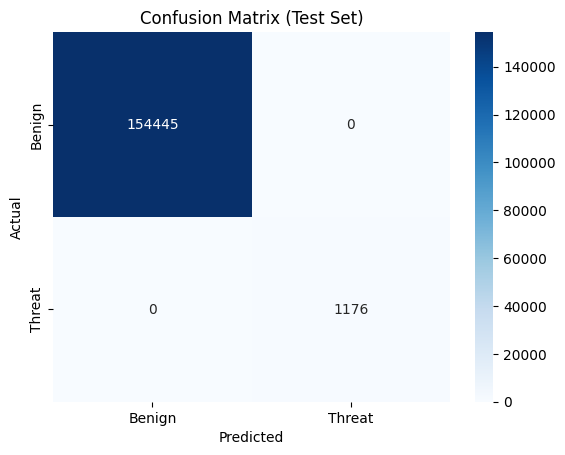

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
print("Confusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Threat'], yticklabels=['Benign', 'Threat'])
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix (Test Set)'); plt.show()

In [30]:
# Evaluate on the training set
y_train_pred = best_rf.predict(X_train_resampled)
print("classification_report for Random Forest(train data):\n", classification_report(y_train_resampled, y_train_pred))
print("Confusion Matrix:", confusion_matrix(y_train_resampled, y_train_pred))

classification_report for Random Forest(train data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    360371
           1       1.00      1.00      1.00    360371

    accuracy                           1.00    720742
   macro avg       1.00      1.00      1.00    720742
weighted avg       1.00      1.00      1.00    720742

Confusion Matrix: [[360371      0]
 [     0 360371]]


In [31]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])
print("\n ROC AUC Score:", roc_auc)


 ROC AUC Score: 1.0


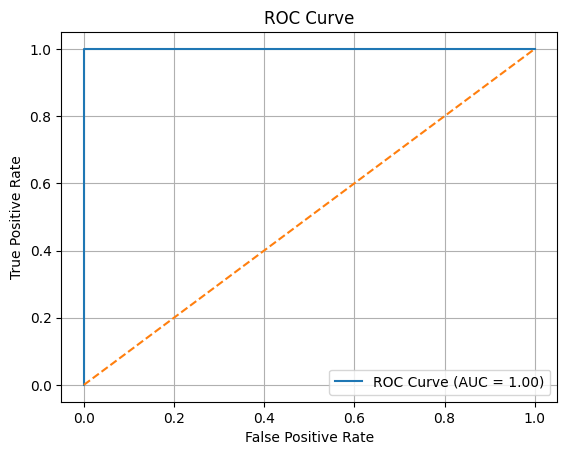

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, best_rf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve')
plt.legend(); plt.grid(); plt.show()

In [33]:
#from sklearn.model_selection import cross_val_score
#cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')